### Author: Navule Pavan Kumar Rao
## Naive Bayes Implementation from the scratch

Download the Email dataset from https://drive.google.com/file/d/0BxNo5NMmppJ1eW1leW9xbDFXTUk/view. This dataset is from Lingspam dataset. There are two types of emails, "spam" and "non-spam".

#### Pre-Processing

In [1]:
import pandas as pd
import numpy as np
import os, errno, glob

In [2]:
data_folder="data\\2\\EmailsData"

In [3]:
def get_filenames(train_test):
    folder_spam=''
    folder_non_spam=''
    #define folder paths
    if train_test == 'train':
        folder_spam =os.path.join(os.path.dirname('__file__'), data_folder + '\\spam-train')
        folder_non_spam = os.path.join(os.path.dirname('__file__'), data_folder + '\\nonspam-train')
    elif train_test == 'test':
        folder_spam =os.path.join(os.path.dirname('__file__'), data_folder + '\\spam-test')
        folder_non_spam = os.path.join(os.path.dirname('__file__'), data_folder + '\\nonspam-test')
    # get all file names in training
    fn_spm=[os.path.join(folder_spam, each)
            for each in os.listdir(folder_spam)]
    fn_non_spm = [os.path.join(folder_non_spam, each)
            for each in os.listdir(folder_non_spam)]
    return fn_spm,fn_non_spm

In [4]:
def get_all_email_text_file_names_and_targets():
    tr_spm,tr_non_spm = get_filenames('train')
    tst_spm,tst_non_spm=get_filenames('test')
    train_fn=np.append(tr_spm,tr_non_spm)
    test_fn=np.append(tst_spm,tst_non_spm)
    print(' training spam:{0} \n training non-spam:{1} \n test spam:{2} \n test non-spam {3} '.format(len(tr_spm),len(tr_non_spm),len(tst_spm),len(tst_non_spm)))
    all_fn=np.append(train_fn,test_fn)
    print('total no. of files read {0}'.format(len(all_fn)))
    train_target=np.append(np.ones(len(tr_spm),dtype=np.int),np.zeros(len(tr_non_spm),dtype=np.int))
    test_target=np.append(np.ones(len(tst_spm),dtype=np.int),np.zeros(len(tst_non_spm),dtype=np.int))
    return all_fn, train_target, test_target

Implement own Naive Bayes classifer to categorize emails as "spam" or "non-spam". To convert the text data into vectors, you can use TfidfVectorizer from here http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html.

#### Vectorize input dataset using TfidfVectorizer

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
def get_tf_idf_vector(file_names):
    tfidf = TfidfVectorizer(input='filename', 
                            token_pattern='(?u)\\b[a-zA-Z]\\w{2,}\\b',
                            stop_words='english')
    vect=tfidf.fit_transform(file_names)
    return vect

### Custom Navie Bayes Implementation

##### Step 1
##### Implement a method that gets Gaussian Likelihood Formula 
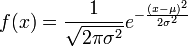

Where:

   µ: Mean or expectation (location of the peak)
   
   σ: Standard deviation
   
   x: The independent random variable
   
Img source: http://www.endmemo.com/statistics/gaussian.php

In [6]:
def get_gaussian_likelihood(x, mean, std):
    variance=std**2
    exponent_func = np.exp(-0.5*((x-mean)/std)**2)
    denominator = np.sqrt( 2*np.pi* variance)
    gauss=exponent_func/denominator
    return gauss

##### Step 2
##### Perform Dimentionality Reduction
Reduce the dataset to say, K=50 dimensions in order to improve the variance and decrease the bias 

In [7]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
def get_dataset_reduced_to_K_dimensions(data,target,K):
    k_selected_fts = SelectKBest(mutual_info_classif, k = K)
    ds= k_selected_fts.fit_transform(data, target)
    return ds[:700,:], ds[700:, :]

In [8]:
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
def generate_report(predicted,actual):
    accuracy=len(predicted[predicted == actual])/len(predicted)
    print('accuracy:',accuracy)
    f1_scr=f1_score( actual, predicted)
    print('f1 score:',f1_scr)
    confusion_mat=confusion_matrix(actual, predicted)
    print('Confusion Matrix: \n',confusion_mat)
    auc=roc_auc_score( actual, predicted)
    print('AUC:',auc)

##### Step 3
##### Implement Navie Bayes classifier 

Lets build a Custom Navie Bayes that has similar methods to that of scikit learn's GaussianNB ie fit and predict
fit() method takes the training data holding attribute values as first arg and target variable collection as second arg
predict() method takes the test attributes and returns the predicted outcome target classifications

http://blog.hackerearth.com/introduction-naive-bayes-algorithm-codes-python-r

In [9]:
class naive_bayes(object):
    def fit(self, X_train, y_train):
        self.class_labels = np.unique(y_train)
        self.means = {}
        self.std = {}
        self.y_prob = {}
        for c in self.class_labels:
            self.means[c] = []
            self.std[c] = []
            self.y_prob[c] = len( y_train[ y_train == c])/len(y_train)
            temp = X_train[y_train == c]
            for col in range(temp.shape[1]):
                self.means[c].append(temp[:, col].mean())
                self.std[c].append(temp[:, col].std())
        
    def predict(self, X_test):
        predicted = np.zeros(X_test.shape[0])
        count = 0
        for row in X_test:
            pred_classes = np.zeros(self.class_labels.shape[0])
            for c in self.class_labels:
                pred_classes[c] = 0
                prod = 1
                for i in range(len(row)):
                    mean = self.means[c][i]
                    std  = self.std[c][i]
                    '''Skip for 0 variance i.e., square of standard deviation = 0
                    this is in order to 
                    get rid of gaussian distribution calculation has variance in the denominator 
                    that leads to divide by zero exceptions
                    '''
                    if std**2 == 0:
                        continue
                    gaus = get_gaussian_likelihood(row[i], mean,std)
                    prod *= gaus
                pred_classes[c] = self.y_prob[c] * prod
            predicted[count] = self.class_labels[pred_classes.argmax()]
            count+=1
        return predicted

##### Step 4
##### Load input data and Pre-Processing
Load data and get tfidf vector which needs to be feed as input for custom naive_bayes and sklearn GaussianNB algorithms

In [10]:
file_names,y_train, y_test = get_all_email_text_file_names_and_targets()
%time vector=get_tf_idf_vector(file_names)

 training spam:350 
 training non-spam:350 
 test spam:130 
 test non-spam 130 
total no. of files read 960
Wall time: 429 ms


In [11]:
target=np.append(y_train, y_test)
%time X_train, X_test= get_dataset_reduced_to_K_dimensions(vector.toarray(),target,50)

Wall time: 3min 28s


##### Step 5
##### Invoke custom naive_bayes Implementation

Train Naive Bayes on data given in folder "nonspam-train" and "spam-train". Test it on emails given in folder "nonspam-test" and "spam-test".

In [12]:
nb = naive_bayes()
nb.fit(X_train, y_train)
%time custom_predicted = nb.predict(X_test)

Wall time: 227 ms


##### Step 6
##### Scikit Learn Implementation of Naive Bayes

Use sklearn's inbuilt Naive Bayes classifer to train on the same dataset.

In [13]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
model=nb.fit(X_train, y_train)
%time sklrn_predicted=model.predict(X_test)

Wall time: 0 ns


##### Step7 
Report accuracy, F1-score, confusion matrix and area under ROC curve (AUC). Also, report your observations from the result.
Compare the performance on test dataset with your implementation.

Confusion Matrix generated by sklearn.metrics will have the following structure

[[tn, fp] 

[fn, tp]]

In [14]:
print("*******************************************")
print("Report for Custom Naive Bayes Implementaion")
print("*******************************************")
generate_report(custom_predicted,y_test)
print("*******************************************")
print("Report for scikit-learn Naive Bayes Implementaion")
print("*******************************************")
generate_report(sklrn_predicted,y_test)
print("*******************************************")

*******************************************
Report for Custom Naive Bayes Implementaion
*******************************************
accuracy: 0.9576923076923077
f1 score: 0.95785440613
Confusion Matrix: 
 [[124   6]
 [  5 125]]
AUC: 0.957692307692
*******************************************
Report for scikit-learn Naive Bayes Implementaion
*******************************************
accuracy: 0.9653846153846154
f1 score: 0.966542750929
Confusion Matrix: 
 [[121   9]
 [  0 130]]
AUC: 0.965384615385
*******************************************


##### Observations:
We notice that the sklearn NB classifier is able to have 0 false negatives compared to 5 with custom implementation and hence the accuracy is more for sklearns NB classifier.
    
We also observe that the custom implementation and sklearn's Naive Bayes Classifier are having almost similar scores but is expected to vary for large and complex datasets in real time situations    